In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numexpr as ne
import math
from IPython.display import display, Math

# 1D Random walks

Write a code (e.g. see rw1d.f90) that simulates numerically a 1D random
walk with a Monte Carlo approach and gives the final position $x_N$ (and
$x^2_N$ ) after N steps with fixed length and probabilities $p_{\gets} $ and $p_{\rightarrow}$ of
moving left and right. Without any loss of generality, you can consider
$x_0=0$ as starting position, and $l=1$.  
The code should calculate also averages over many different walkers (starting from different seeds):
$\langle x_N \rangle$,$\langle x_N^2 \rangle$, and the mean square displacement $\langle \Delta x_N^2 \rangle= \langle x_N^2 \rangle-\langle x_N \rangle^2$.
For comparison, the corresponding exact analytical (“theoretical”) results
are:

\begin{align*}
\langle x_N \rangle^{th}&= N(p_{\gets}-p_{\rightarrow})l;\\
\langle x_N^2 \rangle^{th}&= [N(p_{\gets}-p_{\rightarrow})l]^2+4p_{\gets}p_{\rightarrow}Nl^2;\\
\langle \Delta x_N^2 \rangle^{th}&= \langle x_N^2 \rangle^{th}-\langle x_N \rangle^{th}=4p_{\gets}p_{\rightarrow}Nl^2 .
\end{align*}

In [2]:
class rand_walks:
    
    '''
    This class simulates the 1D Random walk 
    '''
    
    def __init__(self,x_0,p_l,l,n_steps,n_walkers,seed):
        'Initialize the process'
        self.x_0 = x_0 #Initial position
        self.p_l = p_l #Transition Probability
        self.l = l #Dimension of one move
        self.n_steps = n_steps+1 #Number of Steps
        self.n_walkers = n_walkers #Number of Walkers
        self.x_N = [[0 for z in range(self.n_steps)] for _ in range(self.n_walkers)]
        self.S_N = np.zeros(self.n_steps)
        self.Q_N = np.zeros(self.n_steps)
        self.D = np.zeros(self.n_steps)
        self.Delta=np.zeros(self.n_steps)
        self.P_N = np.zeros(self.n_walkers)
        
        for j in range(self.n_walkers): #Initialize 
            self.x_N[j][0]=x_0
        
        self.rng = np.random.default_rng(seed)
        print('Initial position: {} \np_l: {}\nDisplacement: {}\nNumber of steps: {}\nNumber of walkers: {}\n'.format(self.x_0,self.p_l,self.l, self.n_steps-1,self.n_walkers))
        
        
    def run(self):
        #Average over Walkers sample
        for i in range(1,self.n_steps):
            y=self.rng.random(self.n_walkers)
            for j in range(self.n_walkers):
                if y[j]<=self.p_l:
                    self.x_N[j][i]=self.x_N[j][i-1]-self.l
                else: 
                    self.x_N[j][i]=self.x_N[j][i-1]+self.l
                self.S_N[i]=self.S_N[i]+self.x_N[j][i]/self.n_walkers
                self.Q_N[i]=self.Q_N[i]+((self.x_N[j][i])**2)/self.n_walkers
                if i==self.n_steps-1:
                     self.P_N[j]= self.x_N[j][i] #Save last Positions
        
    def visualize_mean(self): 
        plt.plot(self.S_N,label=r'$\langle x \rangle$',color="#1E90FF")
        z= np.linspace(0,100,self.n_steps)
        r = list(map(lambda x: self.x_0,z))
        plt.title("Mean")
        plt.plot(r,color="#FF4500",label=r'$\langle x \rangle^{{th}}={}$'.format(self.x_0))
        plt.xlabel('Step')
        plt.ylabel(r'$\langle x \rangle$')
        plt.legend()
        plt.show()
    
    def visualize_q(self):
        plt.plot(self.Q_N,label=r'$\langle x^2 \rangle$',color="#1E90FF")
        z= np.linspace(0,self.n_steps,self.n_steps)
        r = list(map(lambda x: x*(self.l**2),z))
        plt.title("Mean Squared")
        plt.plot(r,color="#FF4500", label=r'$\langle x_N^2 \rangle^{{th}}={}\cdot x$'.format(self.l**2))
        plt.xlabel('Step')
        plt.ylabel(r'$\langle x^2 \rangle$')
        plt.legend()
        plt.show()
        
    def visualize_std(self):
        self.D=self.Q_N-self.S_N**2
        plt.title("Mean Square Displacement")
        plt.plot(self.D,label=r'$\langle \Delta x^2 \rangle$',color="#1E90FF")
        z= np.linspace(0,self.n_steps,self.n_steps)
        r = list(map(lambda x: ((self.l)**2)*x,z))
        plt.plot(r,color="#FF4500", label=r'$\langle \Delta x_N^2 \rangle^{{th}}={}\cdot N$'.format(self.l**2))
        plt.xlabel('Step')
        plt.ylabel(r'$\langle \Delta x^2 \rangle$')
        plt.legend()
        plt.show()  
    
    def histogram(self):
        plt.title("Histogram $P_N(x)$")
        plt.xlabel('x')
        plt.ylabel(r'Walkers in position x in the N-th step')
        plt.hist(self.P_N,edgecolor="Black", color="#1E90FF")
        plt.show() 
    
    def P_N_x(self):
        return self.P_N

    def var(self):
        self.D=self.Q_N-self.S_N**2
        self.Delta=np.abs(self.D/((self.l**2)*self.n_steps)-1)
        return self.D, self.Delta
        

(a) For the sake of definiteness, choose $p_{\gets} = p_{\rightarrow}= 0.5$ and fix N. In order
to follow the evolution of a random walk with the number of steps,
calculate and plot the instantaneous position, i.e., $x_i$ and $x^2_i$ vs. i, with i from 0 to N. Plot together the results for runs corresponding to different seeds. Do the results change? How do they compare with the expected theoretical behavior $\langle x_N \rangle^{th} = 0$ and$\langle x_N^2 \rangle^{th}=il^2$?  
In particular, consider the final values, $x_N$ and $x^2_N$ and compare them with the theoretical ones, $\langle x_N \rangle^{th} = 0$ and $\langle x_N^2 \rangle^{th}=Nl^2$.

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 1000
Number of walkers: 1



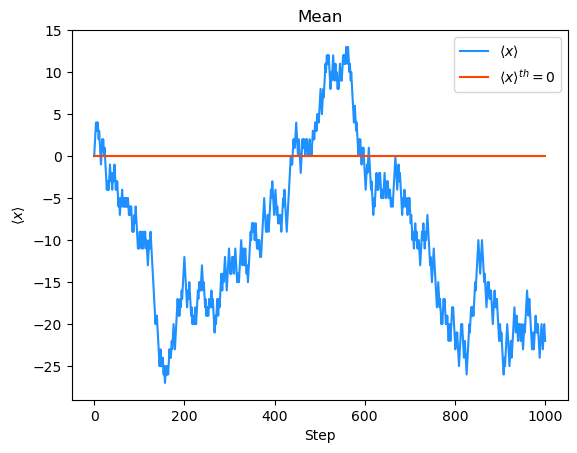

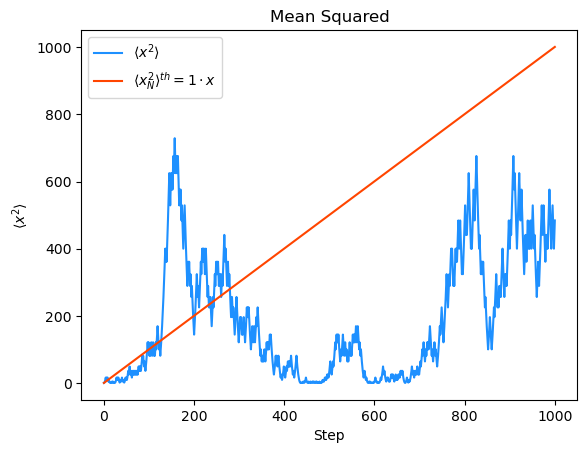

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 1000
Number of walkers: 1



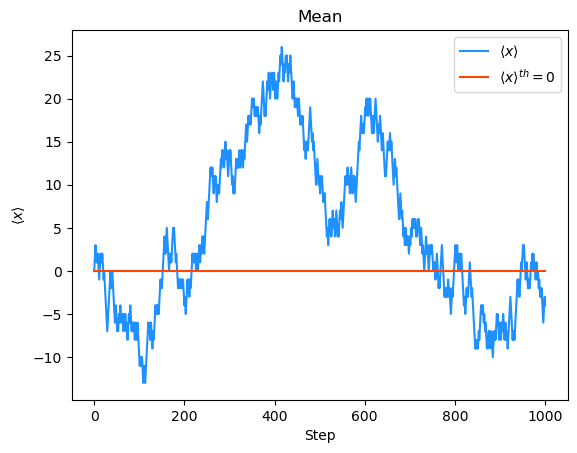

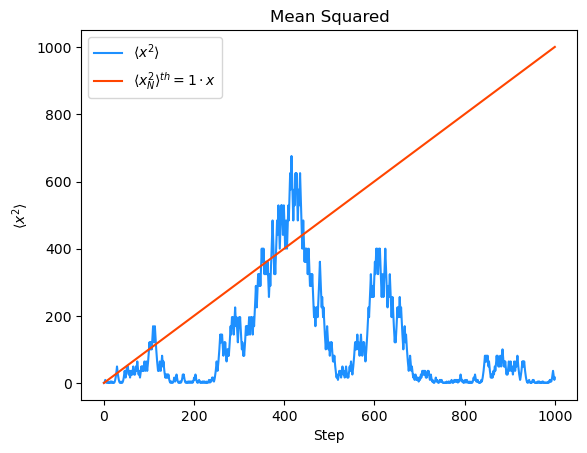

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 1000
Number of walkers: 1



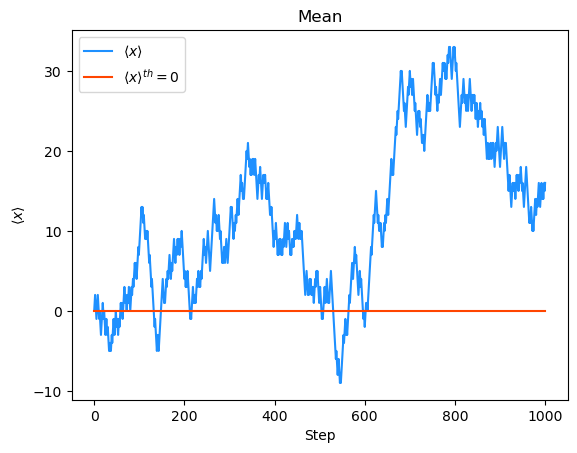

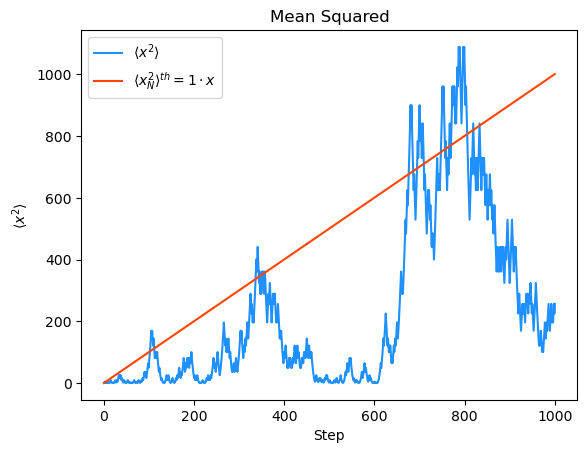

In [3]:
for i in [50, 500, 55]:
    rd=rand_walks(0, 0.5, 1, 1000, 1, seed=i)
    rd.run()
    rd.visualize_mean()
    rd.visualize_q()

(b) Calculate now the averages over many walkers for the instantaneous quantities $\langle x_i \rangle$ $\langle x_i^2 \rangle$ and $\langle (\Delta x_i)^2 \rangle$, and the final ones $\langle x_N \rangle$ $\langle x_N^2 \rangle$ and $\langle (\Delta x_N)^2 \rangle$ and compare also these results with the theoretical values.
What do you observe now?


Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 1000
Number of walkers: 1000



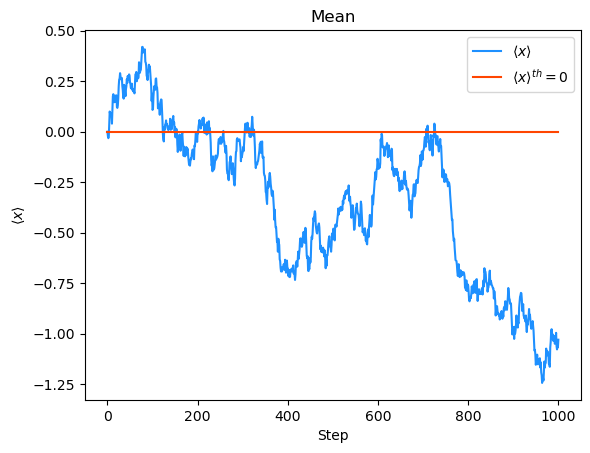

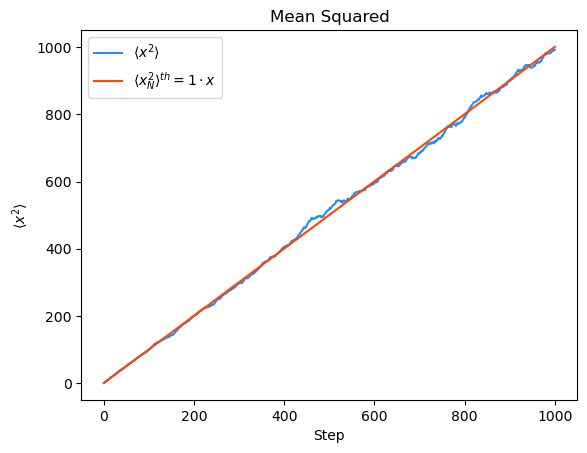

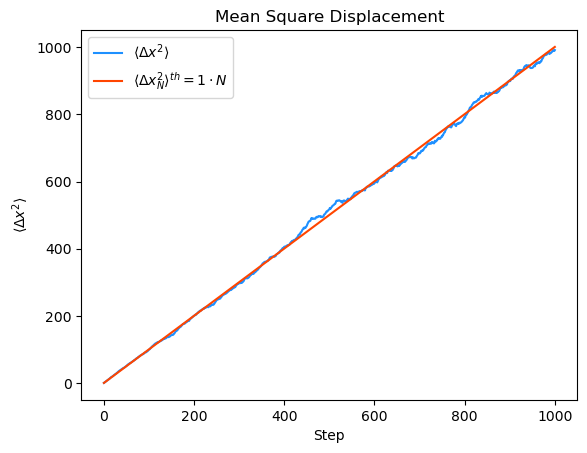

In [4]:
rd=rand_walks(0, 0.5, 1, 1000, 1000, seed=50)
rd.run()
rd.visualize_mean()
rd.visualize_q()
rd.visualize_std()

(c) Calculate the accuracy of the mean square displacement, given by the relative deviation of the numerical value with respect to the theoretical value:

\begin{equation*}
\Delta=\bigg\lvert \frac{\langle \Delta x_N^2 \rangle}{\langle \Delta x_N^2 \rangle^{th}}-1 \bigg\rvert .
\end{equation*}

You should recognize that the larger is the number of walks for the
average, the smaller is $\Delta$. How many walkers are needed to obtain a
“good” result, i.e. for istance with a relative accuracy with $\Delta \leq 5 \%$
respect to the expected behavior?

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 100

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 1000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 10000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 50000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 100000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 500000



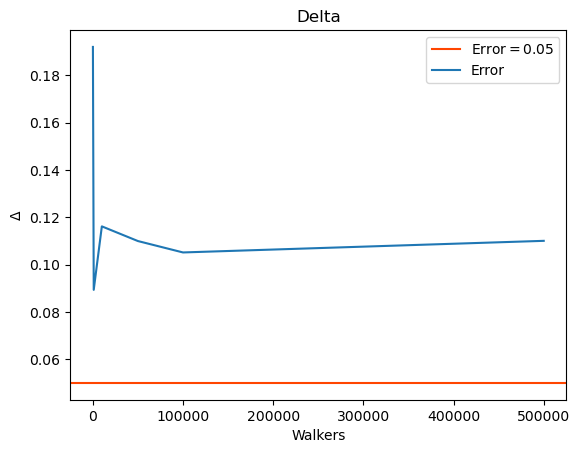

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 100

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 1000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 10000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 50000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 100000

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 500000



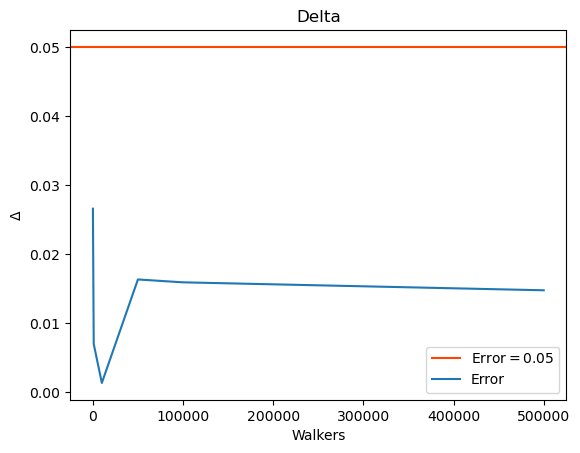

Delta for 8 steps: [0.19204444 0.08934444 0.11618496 0.10997587 0.10515756 0.11006592]
Delta for 8 steps divided by 8: [0.02400556 0.01116806 0.01452312 0.01374698 0.0131447  0.01375824]
Delta for 64 steps: [0.026590769230769973, 0.0070094769230811815, 0.001378585230787599, 0.016348948701402577, 0.015934275175731316, 0.014784753748248947]


In [5]:
Delta=np.zeros(6)
Delta_=[]
j=0

for i in [100,1000,10000,50000,100000,500000]:
    rd=rand_walks(0,0.5,1,8,i,seed=50)
    rd.run()
    Delta[j]=rd.var()[1][-1]
    j+=1

plt.title("Delta")
plt.xlabel('Walkers')
plt.ylabel(r'$\Delta$')
plt.axline((0,0.05), (7,0.05), color='#FF4500',label='Error$=0.05$')
plt.plot([100,1000,10000,50000,100000,500000],Delta,label='Error')
plt.legend()
plt.show()
    
for i in [100,1000,10000,50000,100000,500000]:
    rd=rand_walks(0,0.5,1,64,i,seed=50)
    rd.run()
    Delta_.append(rd.var()[1][-1])

plt.title("Delta")
plt.xlabel('Walkers')
plt.ylabel(r'$\Delta$')
plt.axline((0,0.05), (7,0.05), color='#FF4500',label='Error$=0.05$')
plt.plot([100,1000,10000,50000,100000,500000],Delta_,label='Error')
plt.legend()
plt.show()

print("Delta for 8 steps:", Delta)
print("Delta for 8 steps divided by 8:", Delta/8)
print("Delta for 64 steps:", Delta_)

(d)(optional) Keep fix $p_{\gets} =p_{\rightarrow}=0.5$ and vary $N$. Compare analytical
and numerical results for $\langle x_N^2 \rangle-\langle x_N \rangle^2$ increasing N (Consider for
instance N=8, 16, 32, 64). Does the number of walks necessary to
obtain a given accuracy change with N?

In [6]:
for i in [8, 16, 32, 64]:
    rd=rand_walks(0,0.5,1,i,1000,seed=50)
    rd.run()
    print("Mean Squared Displacement:", rd.var()[0][i])
    print("Error:",np.abs(rd.var()[0][i]-i)/i)
    print("Error riscalated (to confront with {} step error):".format(2*i),np.abs(rd.var()[0][i]-i)/(2*i),"\n")

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 1000

Mean Squared Displacement: 8.195899999999884
Error: 0.024487499999985562
Error riscalated (to confront with 16 step error): 0.012243749999992781 

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 16
Number of walkers: 1000

Mean Squared Displacement: 17.32766399999989
Error: 0.08297899999999303
Error riscalated (to confront with 32 step error): 0.041489499999996515 

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 32
Number of walkers: 1000

Mean Squared Displacement: 34.01324399999998
Error: 0.06291387499999934
Error riscalated (to confront with 64 step error): 0.03145693749999967 

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 1000

Mean Squared Displacement: 64.54438399999972
Error: 0.008505999999995684
Error riscalated (to confront with 128 step error): 0.004252999999997842 



(e) Fix $p_{\gets} =p_{\rightarrow}=0.5$ consider a number of walks (see point (c)) large
enough to have a “good” accuracy for the numerical estimate of $\langle \Delta x_N^2 \rangle^{th}.$
Determine the dependence of $\langle \Delta x_N^2 \rangle$  on N.

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 10000



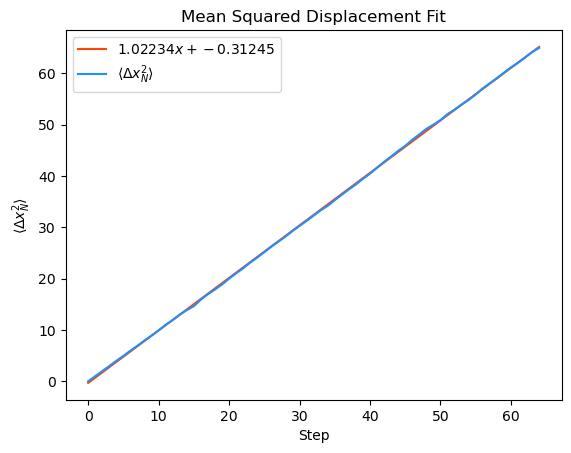

In [7]:
def law(x, a, q):
    return a*x + q

rnd=rand_walks(0,0.5,1,64,10000,seed=50)
rnd.run()

x_interval_for_fit = range(65)
popt, _ = curve_fit(law, x_interval_for_fit ,rnd.Q_N)
plt.title("Mean Squared Displacement Fit")
plt.xlabel("Step")
plt.ylabel(r"$\langle \Delta x_N^2 \rangle$")
plt.plot(x_interval_for_fit,law(x_interval_for_fit, *popt),color="#FF4500",label='${:.5f}x+{:.5f}$'.format(popt[0],popt[1]))
plt.plot(rnd.Q_N,color="#1E90FF", label=r'$\langle \Delta x_N^2 \rangle$')
plt.legend()
plt.show()

(f) Insert in the program the calculation of the distribution $P_N$ (numerically, from the simulation) and its expected behaviour:

\begin{equation*}
P_N^{th}=\frac{N!}{(\frac{N}{2}+\frac{x}{2})!(\frac{N}{2}-\frac{x}{2})!}p_{\rightarrow}^{(\frac{N}{2}+\frac{x}{2})}p_{\gets}^{(\frac{N}{2}-\frac{x}{2})} .
\end{equation*}

Consider again the case $p_{\gets} =p_{\rightarrow}=0.5$ and N = 8 and plot $P_N$ and $P_N^{th}$. Compare the two distributions. Is  $P_N(x)$ a continuous function? How can you explain its behaviour?

In [8]:
def fact(N):
    fact=1
    for i in range(N+1):
        if i<=1:
            fact=1
        else:
            fact=fact*i 
    return fact

In [9]:
def P_N_th(N,x,p_l):
    if round(N)%2==0:
        if round(x)%2!=0:
            return 0
        else:
            return (fact(N)/((fact(round(N/2)+round(x/2)))*(fact(round(N/2)-round(x/2)))))*((p_l**(N/2-x/2))*((1-p_l)**(N/2+x/2)))
    else:
        if round(x)%2==0:
            return 0
        else:
            return (fact(N)/((fact(round(N/2+x/2)))*(fact(round(N/2-x/2)))))*((p_l**(N/2-x/2))*((1-p_l)**(N/2+x/2)))

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 10000



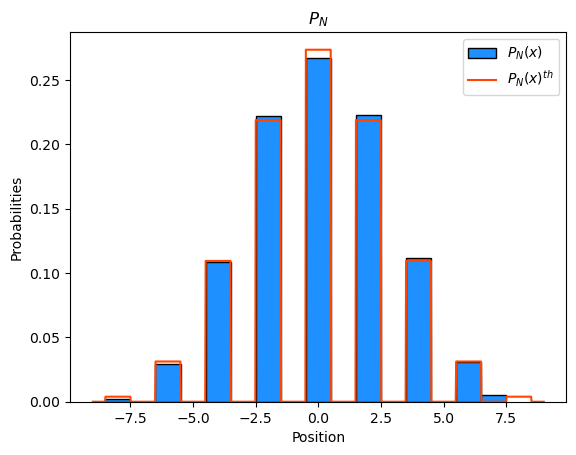

In [10]:
n=8

rnd=rand_walks(0,0.5,1,n,10000,seed=50)
rnd.run()
P_N=rnd.P_N
max_P_N=P_N.max()
min_P_N=P_N.min()

z= np.linspace(min_P_N-1,max_P_N+1,1000)
r = list(map(lambda x: P_N_th(n,x,0.5),z))

plt.title(r"$P_N$")
plt.xlabel("Position")
plt.ylabel("Probabilities")
plt.hist(P_N,bins=round((max_P_N-min_P_N)),align='left',weights=[1/(len(P_N))]*len(P_N),color="#1E90FF",edgecolor='black',label='$P_N(x)$')
plt.plot(z,r,color="#FF4500",label=r'$P_N(x)^{{th}}$')
plt.legend()
plt.show()

(g) For sufficiently large N,  $P_N$ can be approximated with the gaussian distribution:

\begin{equation*}
P_N=\frac{1}{\sqrt{2\pi \sigma ^2}} exp[-(x-\langle x \rangle)^2/2\sigma^2] .
\end{equation*}

Verify by calculating numerically $P_N$ for N=8, 16, 32, 64 and comparing it with P(x), where $\sigma^2$ is numerically estimated. Discuss the results.

In this case we fitted the data with a normal distribution, the results are good: the shape of the gaussian is clear.
In particular, the fit returns the following values
Even in this case, we have to consider a larger sample of walkers, in order to get a better value.

In [11]:
def gaussian(x, standard_deviation,mean):
    return (1/((np.sqrt(2*np.pi))*standard_deviation))*np.exp(-(x-mean)**2 / (2*standard_deviation**2))

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 8
Number of walkers: 10000

Standard deviation: 2.820343128060742
Square root of 8 : 2.8284271247461903

Standard deviation (fit): 2.9314854933352836
Average (fit): 0.03157341117974935


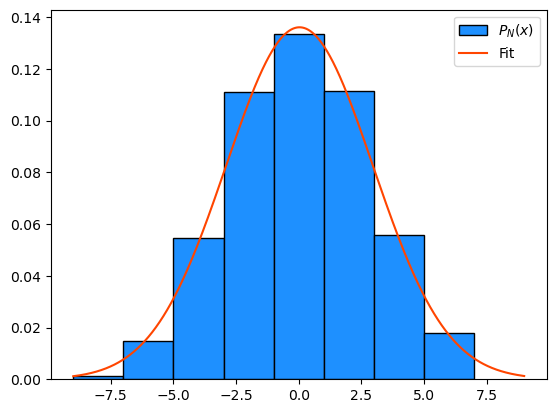

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 16
Number of walkers: 10000

Standard deviation: 3.9891349989692158
Square root of 16 : 4.0

Standard deviation (fit): 4.009822409717697
Average (fit): 0.006958491563686996


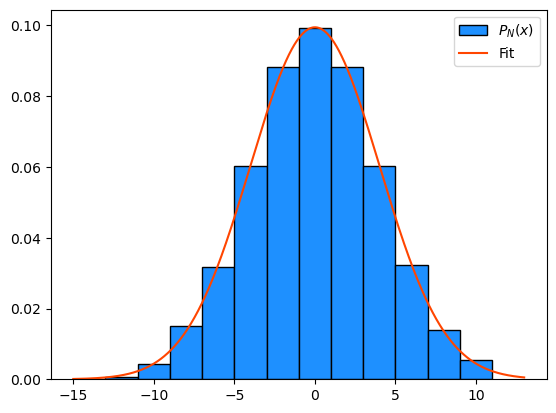

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 32
Number of walkers: 10000

Standard deviation: 5.680139941937851
Square root of 32 : 5.656854249492381

Standard deviation (fit): 5.7003353280799125
Average (fit): 0.03556168504740974


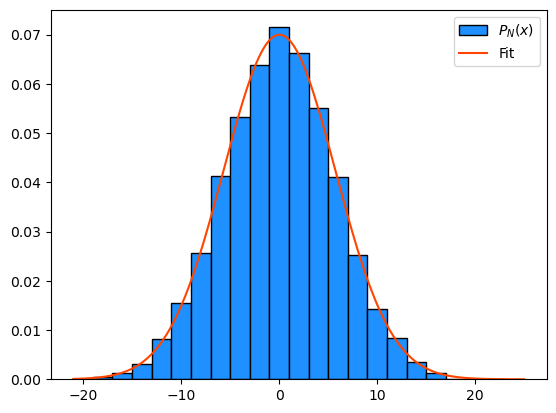

Initial position: 0 
p_l: 0.5
Displacement: 1
Number of steps: 64
Number of walkers: 10000

Standard deviation: 8.05669857696059
Square root of 64 : 8.0

Standard deviation (fit): 8.142629232438185
Average (fit): -0.04208549191346724


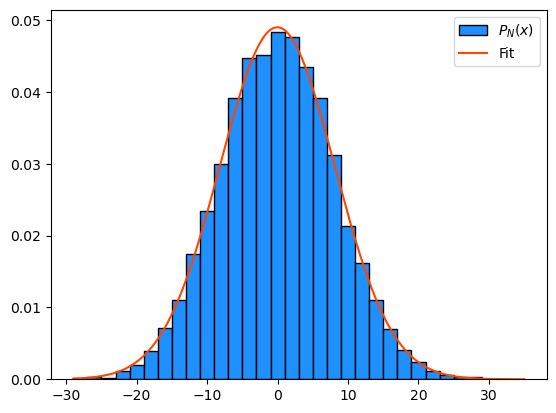

In [12]:
for i in [8, 16, 32, 64]:
    rd=rand_walks(0,0.5,1,i,10000,seed=50)
    rd.run()
    P_N=rd.P_N
    max_P_N=P_N.max()
    min_P_N=P_N.min()
    print("Standard deviation:",np.sqrt(rd.var()[0][-1]))
    print("Square root of", i,":",np.sqrt(i))
    bin_heights, bin_borders, _ = plt.hist(P_N,align='left',bins=int((max_P_N-min_P_N)/2),weights=[1/(2*len(P_N))]*len(P_N),color="#1E90FF",edgecolor='black',label='$P_N(x)$')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2 -1
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights,p0=[np.sqrt(i),0])
    print("\nStandard deviation (fit):" ,popt[0])
    print("Average (fit):" ,popt[1])
    x_interval_for_fit = np.linspace(min_P_N-1, max_P_N+1, 10000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Fit',color="#FF4500")
    plt.legend()
    plt.show()

# Monte Carlo method: generic sample mean and importance sampling


(a) Write a code to compute the numerical estimate $F_n$ of $I =\int_0^1 e^{-x^2} dx \approx\frac{\sqrt{\pi}}{2}\text{erf}(1) \approx 0.746824$ with the MC sample mean method using a set $\{x_i\}$
of $n$ random points uniformly distributed in $[0,1]$:

$$ F_n=\frac{1}{n} \sum^n f(x_i).$$

(b) Write a code (a different one, or, better, a unique code with an option) to compute $F_n$ using the importance sampling with a set $\{x_i\}$ of points generated according to the distribution $p(x) = Ae^{-x}$ (Notice that $\text{erf}(x)$ is an intrinsic fortran function; useful to compare the numerical result with the true value).
Remind that in the importance sampling approach:

$$\int_a^b f(x) dx= \langle \frac{f(x)}{p(x)} \rangle \int_a^b p(x) dx \approx \frac{1}{n} \sum ^n \frac{f(x_i)}{p(x_i)} \int_a^b p(x) dx= F_n$$

with $p(x)$ which approximates the behaviour of $f(x)$, and the average is calculated over the random points $\{x_i\}$ with distribution $p(x)$.

(c) Compare the efficiency of the two sampling methods (uniform and importance sampling) for the estimate of the integral by calculating the following quantities: $F_n$, $\sigma_n=(\langle f_i ^2\rangle-\langle f_i\rangle^2)^{\frac{1}{2}}$, $\sigma_n=\sigma_n/\sqrt{n}$, where $f_i=f(x_i)$ in the first case, and $f_i=\frac{f(x_i)}{p(x_i)}\int^a_b p(x) dx$ in the second case (make a log-log plot of the error as a function of n: what do you see?)

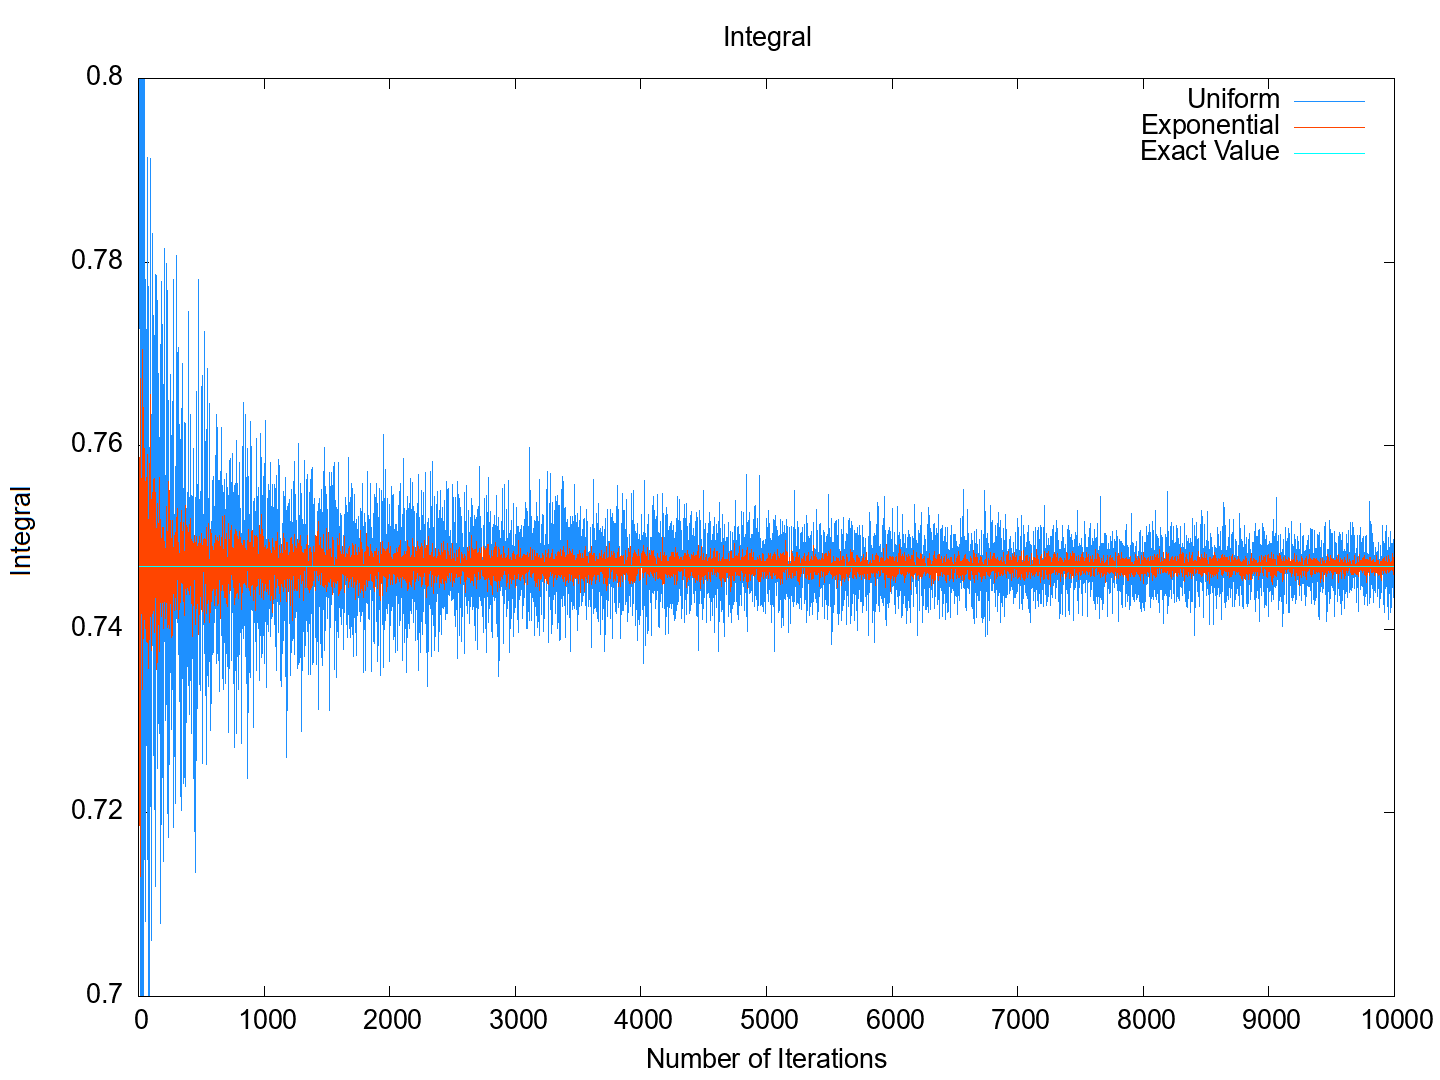

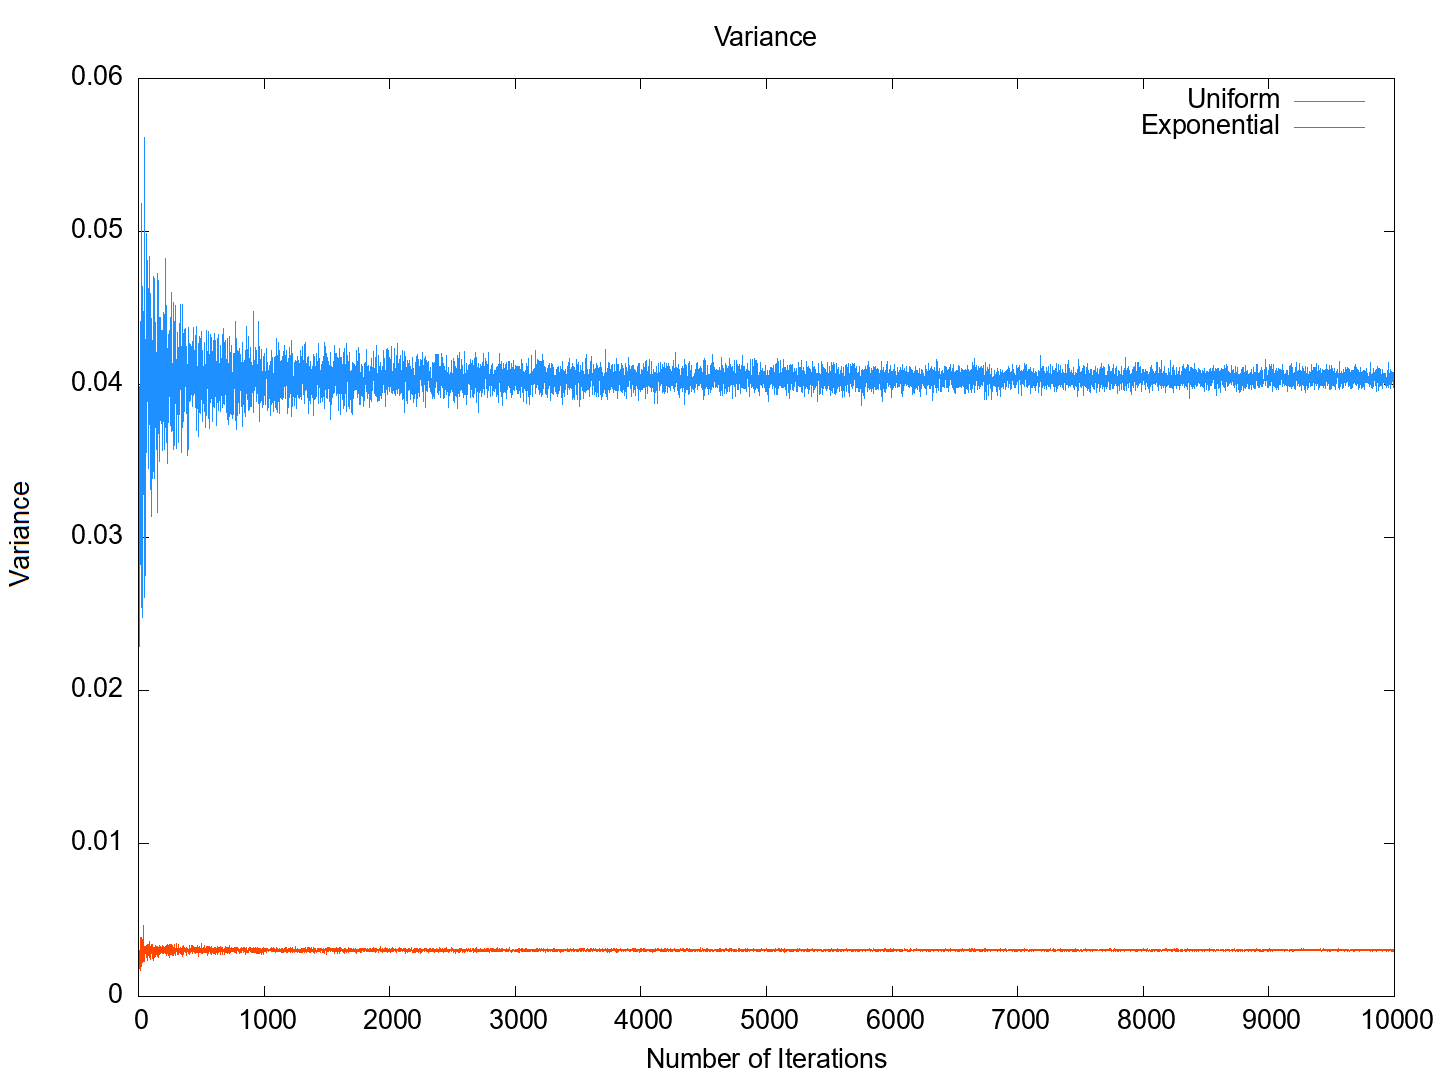

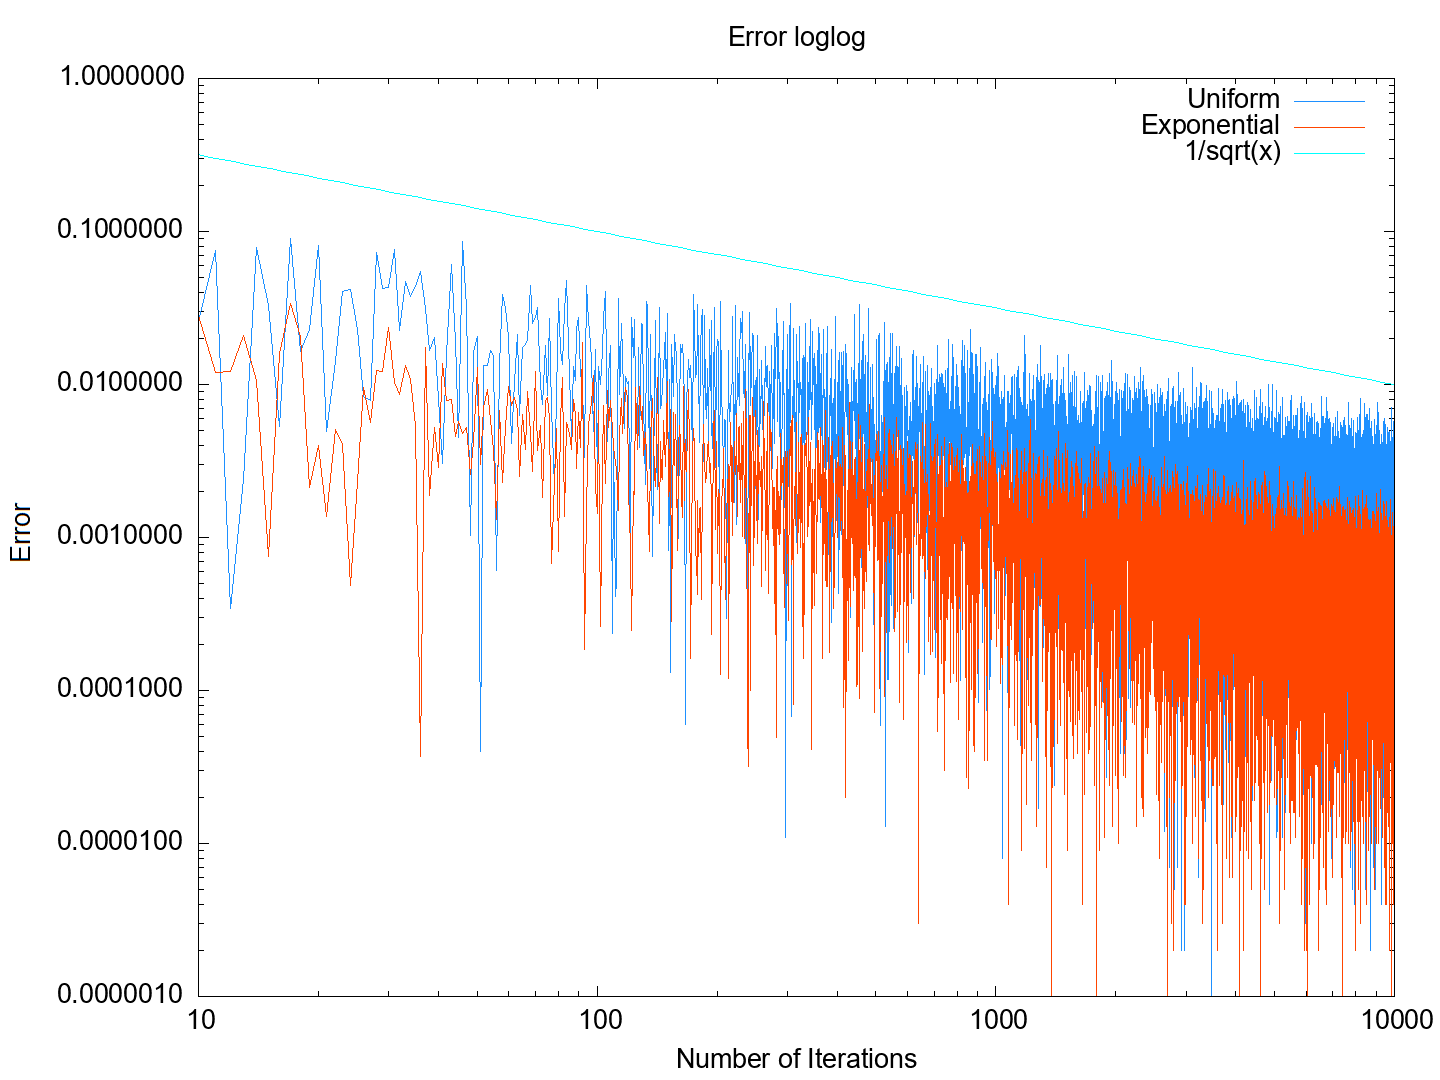

In [14]:
from IPython.display import display, Image
display(Image(filename="Integral.png", height=400, width=400))
display(Image(filename="Variance.png", height=400, width=400))
display(Image(filename="Errorloglog.png", height=400, width=400))

# Monte Carlo method – sample mean (generic); error analysis using the “average of the averages” and the “block average”

(a) Write a code to estimate the same integral of previous exercise, with $I=\int_0^1 \sqrt{1-x^2} dx$ using the MC method of sample mean with uniformly distributed random points. Evaluate the error $\Delta_n=F_n-I$ for $n=10^2, 10^3, 10^4$: it should have a $1/\sqrt{n}$ behaviour.

In [15]:
class Integral:
    '''
    This class calculates \pi 
    through Monte Carlo integration
    '''
    
    def __init__(self,N,seed,numexp=True):
        'Initialise the MC.'
        self.N = N
        self.rng = np.random.default_rng(seed)
        self.I = 0.0
        self.I2 = 0.0
        self.stdvn = 0.0
        self.do_block_averages = None
        self.blocks = None
        self.var = None
        self.numexp = numexp
        
    def f(self,x):
        'Function to integrate.'
        return np.sqrt(1.0-x**2)
    
    def f2(self,x):
        'Square of self.f, computationally faster.'
        return (1.0-x**2)
    
    def compute_mc_integral(self,x):
        'Sample self.f and average.'
        if self.numexp:
            ev = ne.evaluate("(sqrt(1.0-x**2))",optimization='moderate')
            return np.average(ev)
        else:
            return sum(map(self.f, x))/len(x)

    def compute_mc_integral_var(self,x):
        '''
        Sample self.f and calculates
        mean, mean of the square, variance,
        standard deviation
        '''
        I = self.compute_mc_integral(x)
        I2 = sum(map(self.f2, x))/len(x)
        var = (I2 - I**2)
        stdvn =  np.sqrt((I2 - I**2)/len(x))
        return np.array([I,I2,stdvn,var])
        
    def mc_integral(self,block_averages=False,blocks=1):
        'MC integration driver'
        self.do_block_averages = block_averages
        self.blocks = blocks
        r = self.rng.random(self.N)
        if self.do_block_averages and self.blocks!=self.N:
            rs = np.split(r,self.blocks)
            results = np.array(list(map(self.compute_mc_integral,rs)))
            self.I = np.average(results)
            self.I2 =  np.average(results**2)
            self.stdvn = np.sqrt((self.I2 - self.I**2)/results.shape[0])
            self.var = (self.I2 - self.I**2)
        else:
            self.I,self.I2,self.stdvn,self.var = self.compute_mc_integral_var(r)


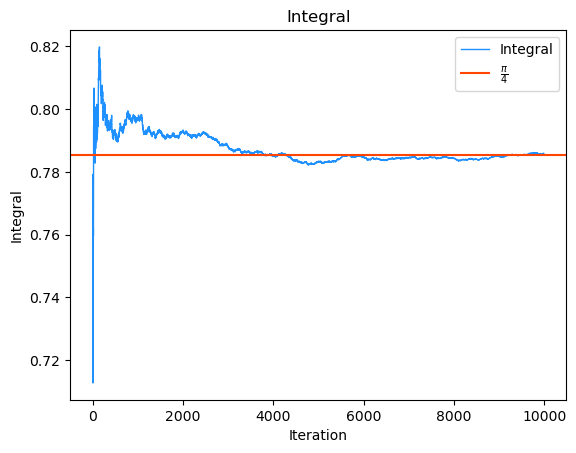

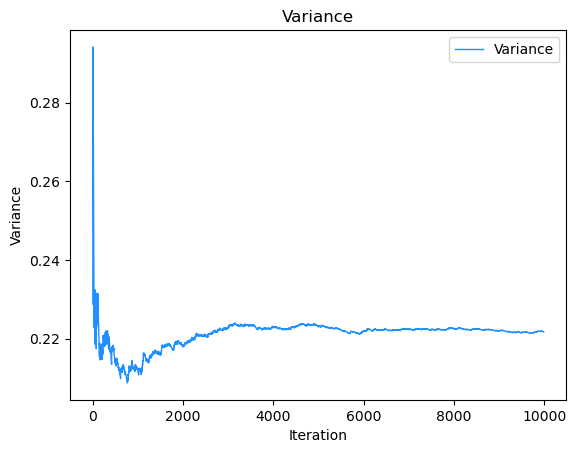

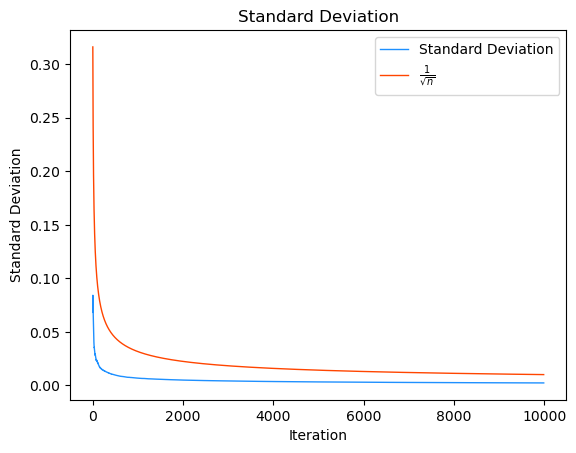

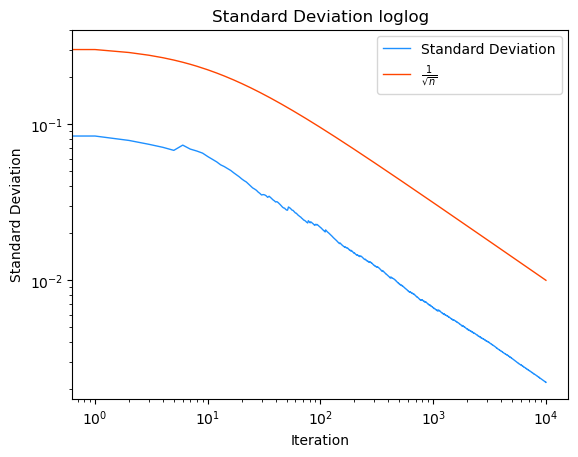

In [16]:
uniform_int=[]
uniform_std=[]
uniform_std_=[]


for N in range(10,10000):
    I=Integral(N,50)
    I.mc_integral()
    uniform_int.append(I.I)
    uniform_std.append(np.sqrt(I.var))
    uniform_std_.append(I.stdvn)
    
plt.title("Integral")    
plt.plot(uniform_int,'-',lw=1,label=r'Integral',color="#1E90FF")
plt.axline((0,(np.pi/4)), (10, (np.pi/4)), label=r"$\frac{\pi}{4}$",color="#FF4500")
plt.xlabel('Iteration')
plt.ylabel('Integral')
plt.legend()
plt.show()

plt.title("Variance")
plt.plot(uniform_std,'-',lw=1,label=r'Variance',color="#1E90FF")
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.legend()
plt.show()

x=np.linspace(10,10000,9989)  
y = list(map(lambda x: (1/np.sqrt(x)),x))

plt.title("Standard Deviation")
plt.plot(uniform_std_,'-',lw=1,label=r'Standard Deviation',color="#1E90FF")
plt.plot(y,'-',lw=1,label=r'$\frac{1}{\sqrt{n}}$',color="#FF4500")
plt.xlabel('Iteration')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

plt.title("Standard Deviation loglog")
plt.loglog(uniform_std_,'-',lw=1,label=r'Standard Deviation',color="#1E90FF")
plt.loglog(y,'-',lw=1,label=r'$\frac{1}{\sqrt{n}}$',color="#FF4500")
plt.xlabel('Iteration')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

In [17]:
err=[]

for N in range(10,10000,1):
    I=Integral(N,50)
    I.mc_integral()
    err.append(np.abs(I.I-np.pi/4))

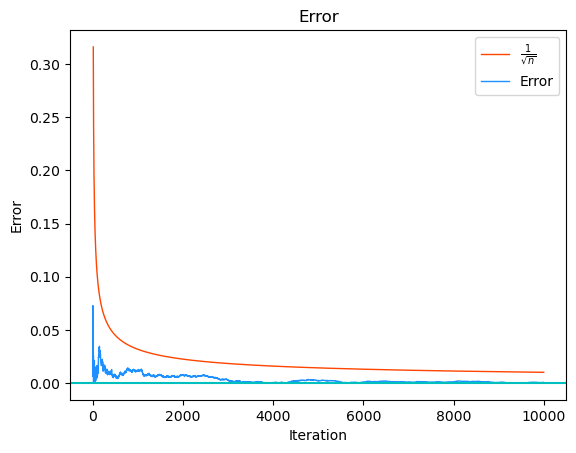

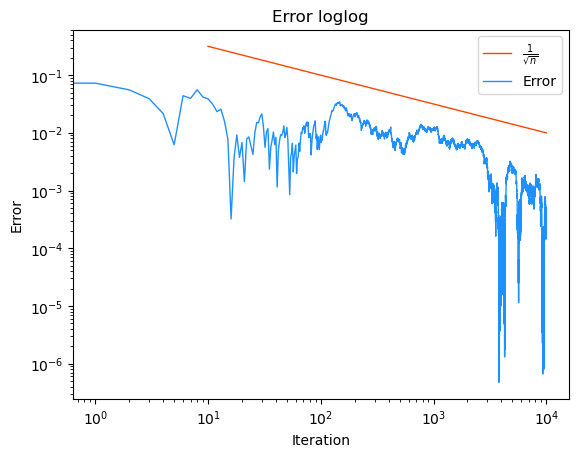

In [18]:
x= np.linspace(10,10000,9990)
y = list(map(lambda x: (1/np.sqrt(x)),x))

plt.title("Error")
plt.plot(x,y,'-',lw=1,label=r'$\frac{1}{\sqrt{n}}$',color="#FF4500")
plt.plot(err,'-',lw=1,label=r'Error',color="#1E90FF")
plt.axline((0,(0)), (97, (0)), color='c')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.plot()
plt.legend()
plt.show()

plt.title("Error loglog")
plt.loglog(x,y,'-',lw=1,label=r'$\frac{1}{\sqrt{n}}$',color="#FF4500")
plt.loglog(err,'-',lw=1,label=r'Error',color="#1E90FF")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.plot()
plt.legend()
plt.show()

(b) Choose in particular $n = 10^4$ and consider the corresponding error $\Delta_n$. Calculate $\sigma_n=(\langle f_i ^2\rangle-\langle f_i\rangle^2)^{\frac{1}{2}}$.You should recognize that $\sigma_n$  CANNOT BE CONSIDERED A GOOD ESTIMATE OF THE ERROR (it’s much larger than the actual error. . . )

100
Standard deviation: 0.22812241949015546
Error: 0.011150792628647599
1000
Standard deviation: 0.21232304099951133
Error: 0.011399551095909843
10000
Standard deviation: 0.22172261127708642
Error: 0.0005292666111530453


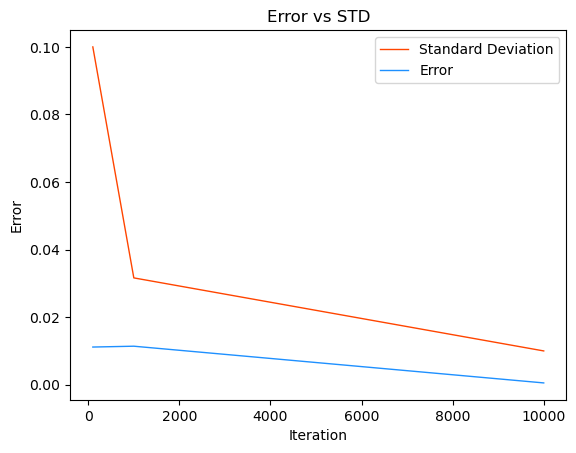

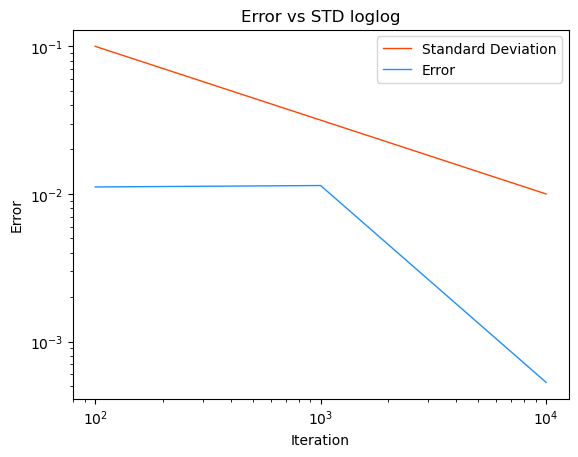

In [19]:
err=[]

for N in [100,1000,10000]:
    I=Integral(N,50)
    I.mc_integral()
    err.append(np.abs(I.I-np.pi/4))
    print(N)
    print('Standard deviation:',np.sqrt(I.var))
    print('Error:', np.abs(I.I-np.pi/4))

x=[100,1000,10000]  
y = list(map(lambda x: (1/np.sqrt(x)),x))

plt.title("Error vs STD")
plt.plot(x,y,'-',lw=1,label='Standard Deviation',color="#FF4500")
plt.plot(x,np.abs(err),'-',lw=1,label=r'Error',color="#1E90FF")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.plot()
plt.show()

plt.title("Error vs STD loglog")
plt.loglog(x,y,'-',lw=1,label='Standard Deviation',color="#FF4500")
plt.loglog(x,np.abs(err),'-',lw=1,label=r'Error',color="#1E90FF")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.plot()
plt.show()

(c) In order to improve the error estimate, apply the following two different methods of variance reduction: 
1) “average of the averages”:  
do m =10 runs with n points each, and consider the average of the averages and its
standard deviation:

$$\sigma_m^2=(\langle M ^2\rangle-\langle M \rangle^2)$$

where

$$\langle M \rangle=\frac{1}{m} \sum^m M_\alpha \ \text{and} \ \langle M^2 \rangle=\frac{1}{m} \sum^m M^2_\alpha$$

and M is the average of each run. You should recognize that 
is a good estimate of the error associated to each measurement (=each run) and $\sigma_m\approx\sigma_n/\sqrt{n}$ is the error associated to the average over the different runs.

In [20]:
I=Integral(10000,50)
I.mc_integral(block_averages=False)

display(Math(r'\text{{Average}}= {}'.format(I.I)))
display(Math(r'\text{{Variance}} \ \sigma_n^2= {}'.format(I.var)))
display(Math(r'\text{{Standard Deviation}} \ \sigma_n= {}'.format(np.sqrt(I.var))))
display(Math(r'\text{{Standard Deviation Normalized}} \ \sigma_n/\sqrt{{n}}= {}'.format(I.stdvn)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
averages=[]

for N in range(10):
    I=Integral(1000,N)
    I.mc_integral(block_averages=False)
    averages.append(I.I)

display(Math(r'\text{{Average}}= {}'.format(np.mean(averages))))
display(Math(r'\text{{Variance}} \ \sigma_m^2= {}'.format(np.std(averages)**2)))
display(Math(r'\text{{Standard Deviation}} \ \sigma_m= {}'.format(np.std(averages))))
display(Math(r'\text{{Standard Deviation Normalized}} \ \sigma_n/\sqrt{{n}}= {}'.format(I.stdvn)))#n--> size of one sample

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(d) 2) Divide now the n = 10000 points into 10 subsets. Consider the averages
fs within the individual subsets and the standard deviation if the average
over the subsets:
$$\sigma_s^2=(\langle f_s ^2\rangle-\langle f_s \rangle^2)$$

You should notice that $\sigma_s/\sqrt{s}\approx\sigma_m$

In [22]:
I=Integral(10000,50)
I.mc_integral(block_averages=True,blocks=10)

display(Math(r'\text{{Avarage}}= {}'.format(I.I)))
display(Math(r'\text{{Variance}} \ \sigma_s^2= {}'.format(I.var)))
display(Math(r'\text{{Standard Deviation}} \ \sigma_s= {}'.format(np.sqrt(I.var))))
display(Math(r'\text{{Standard Deviation}} \ \sigma_s/\sqrt{{s}}= {}'.format(I.stdvn)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>